In [1]:
import os
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

110
n=110
median=302500.0
μ=601085.5
σ=796321.1
n=110
median=231000.0
μ=505388.2
σ=1209844.3
n=110
median=168000.0
μ=345868.2
σ=653262.3
n=110
median=122500.0
μ=296225.5
σ=531616.5


/var/folders/cy/wg7pd_p11rg7b4s4wwvgdnvr0000gn/T/ipykernel_3609/3158521880.py:50: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data, labels=dates, patch_artist=True, notch=True, showfliers=False)


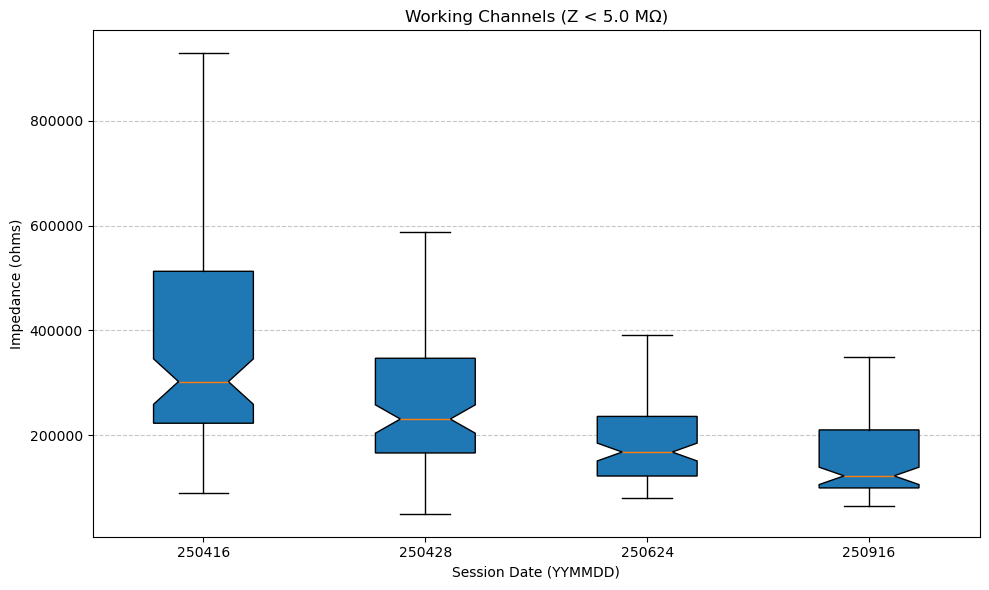

In [59]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt

def plot_impedance_boxplots_working(folder_path, z_threshold=5e6):
    # Find all matching CSV files
    files = sorted(glob.glob(os.path.join(folder_path, "measuredImpedances_preSession_*.csv")))
    
    if not files:
        print("No impedance files found.")
        return
    
    impedance_data = {}
    
    for file_idx, file in enumerate(files):
        # Extract date from filename (YYMMDD)
        basename = os.path.basename(file)
        date_str = basename.split("_")[-1].replace(".csv", "")
        
        # Read CSV
        df = pd.read_csv(file)
        
        col_name = "Impedance Magnitude at 1000 Hz (ohms)"
        if col_name not in df.columns:
            print(f"Column not found in {file}")
            continue
            
        working_vals = df[col_name].dropna()
        if file_idx == 0:
            reference_indeces = (3e4 < working_vals) & (working_vals < z_threshold)
            print(sum(reference_indeces))
        # Filter working channels
        # reference_indeces = (3e4 < working_vals) & (working_vals < z_threshold)        
        working_vals = working_vals[reference_indeces]
        
        if len(working_vals) > 0:
            impedance_data[date_str] = working_vals.values
    
    if not impedance_data:
        print("No working channel data extracted.")
        return
    
    # Prepare data for boxplot
    dates = sorted(impedance_data.keys())
    data = [impedance_data[d] for d in dates]
    
    # Plot
    plt.figure(figsize=(10, 6))
    box = plt.boxplot(data, labels=dates, patch_artist=True, notch=True, showfliers=False)
    # violin = plt.violinplot(data)
    plt.title(f"Working Channels (Z < {z_threshold/1e6:.1f} MΩ)")
    plt.ylabel("Impedance (ohms)")
    # plt.yscale("log")
    plt.xlabel("Session Date (YYMMDD)")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    
    # Add descriptive statistics above each box
    for i, d in enumerate(dates, start=1):
        vals = impedance_data[d]
        mean = vals.mean()
        median = pd.Series(vals).median()
        std = vals.std()
        n = len(vals)
        stats_text = f"n={n}\nmedian={median:.1f}\nμ={mean:.1f}\nσ={std:.1f}"
        print(stats_text)
        # plt.text(i, max(vals) * 1.05, stats_text,
        #          ha="center", va="bottom", fontsize=8)
    
    plt.tight_layout()
    plotname = "rEO_11-chronic_impedances.pdf"
    plt.savefig(os.path.join(folder_path, plotname), format='pdf')
    plt.show()


# Example usage:
plot_impedance_boxplots_working("/Users/eminhanozil/Yanik Lab Dropbox/Eminhan Özil/Localization Manuscript 2024/RAT DATA/rEO_11")


In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

def plot_working_channel_impedance_by_days_with_sem(data_by_category, output_path):
    """
    Plot mean ± SEM impedance over time using days since first recording as x-axis,
    and save the plot to a PDF file.

    Args:
        data_by_category (dict): Dictionary with impedance time series data per category.
        output_path (str): Full path to the output PDF file.
    """
    plt.figure(figsize=(10, 6))
    mrid_all = []
    control_all = []
    up_thr = 5e5
    low_thr = 3e4
    
    for category, data in data_by_category.items():
        dates = [entry["date"] for entry in data["time_series"]]
        first_date = dates[0]
        days_since_start = [(date - first_date).days for date in dates]

        means = []
        sems = []
        for entry in data["time_series"]:
            impedances = entry["reference_impedances"]
            working = [imp for imp in impedances if imp < up_thr and imp > low_thr ]
            working = entry["reference_impedances"]
            if working:
                mean_val = np.mean(working)
                sem_val = np.std(working, ddof=1) / np.sqrt(len(working))
                means.append(mean_val)
                sems.append(sem_val)
            else:
                means.append(None)
                sems.append(None)

        plt.errorbar(np.array(days_since_start[1:])*9.2, means[1:], yerr=sems[1:], label=category, marker='o', capsize=3)

    plt.xlabel("Equivalent Days of Aging Since First Recording")
    plt.ylabel("Mean Impedance of Working Channels (ohms)")
    plt.title("Mean ± SEM Impedance of Working Channels Over Time")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plotname = "mean_impedances.pdf"
    # Save as PDF
    plt.savefig(os.path.join(output_path, plotname), format='pdf')
    plt.show()

    print(f"\n✅ Plot saved as PDF to: {output_path}")

    
def save_working_channel_counts(data_by_category, output_dir):
    """
    Saves a CSV file of number of working channels over time per category.

    Args:
        data_by_category (dict): Data structure with time_series info.
        output_dir (str): Path where CSV will be saved.
    """
    # Collect all unique dates across categories
    all_dates = set()
    for data in data_by_category.values():
        for entry in data["time_series"]:
            all_dates.add(entry["date"])
    all_dates = sorted(all_dates)

    # Create a DataFrame indexed by date
    df = pd.DataFrame(index=all_dates)

    # Fill DataFrame with counts from each category
    for category, data in data_by_category.items():
        date_to_count = {entry["date"]: entry["num_working"] for entry in data["time_series"]}
        df[category] = df.index.map(lambda d: date_to_count.get(d, None))

    # Save to CSV
    output_path = os.path.join(output_dir, "working_channels_summary.csv")
    df.index.name = "Date"
    df.to_csv(output_path)

    print(f"\n✅ CSV saved to: {output_path}")

def save_dead_pedot_channels(data_by_category, output_dir):
    """
    Saves a CSV file of number of working channels over time per category.

    Args:
        data_by_category (dict): Data structure with time_series info.
        output_dir (str): Path where CSV will be saved.
    """
    # Collect all unique dates across categories
    all_dates = set()
    for data in data_by_category.values():
        for entry in data["time_series"]:
            all_dates.add(entry["date"])
    all_dates = sorted(all_dates)

    # Create a DataFrame indexed by date
    df = pd.DataFrame(index=all_dates)

    # Fill DataFrame with counts from each category
    for category, data in data_by_category.items():
        date_to_count = {entry["date"]: entry["no_pedot"] for entry in data["time_series"]}
        df[category] = df.index.map(lambda d: date_to_count.get(d, None))

    # Save to CSV
    output_path = os.path.join(output_dir, "no_pedot_channels_summary.csv")
    df.index.name = "Date"
    df.to_csv(output_path)

    print(f"\n✅ CSV saved to: {output_path}")


def save_delaminated_channels(data_by_category, output_dir):
    """
    Saves a CSV file of number of working channels over time per category.

    Args:
        data_by_category (dict): Data structure with time_series info.
        output_dir (str): Path where CSV will be saved.
    """
    # Collect all unique dates across categories
    all_dates = set()
    for data in data_by_category.values():
        for entry in data["time_series"]:
            all_dates.add(entry["date"])
    all_dates = sorted(all_dates)

    # Create a DataFrame indexed by date
    df = pd.DataFrame(index=all_dates)

    # Fill DataFrame with counts from each category
    for category, data in data_by_category.items():
        date_to_count = {entry["date"]: entry["delaminated or short circuited"] for entry in data["time_series"]}
        df[category] = df.index.map(lambda d: date_to_count.get(d, None))

    # Save to CSV
    output_path = os.path.join(output_dir, "delaminated_channels_summary.csv")
    df.index.name = "Date"
    df.to_csv(output_path)

    print(f"\n✅ CSV saved to: {output_path}")

In [3]:

# Define the root path
root_path = "/Users/eminhanozil/Yanik Lab Dropbox/Eminhan Özil/Localization Manuscript 2024/in vitro/Accelerated Aging/impedances/"

# Dictionary to hold all data
data_by_category = {}
up_thr = 5e5
low_thr = 3e4

print("\n=== Impedance Analysis ===")

# Loop through each category folder
for category in os.listdir(root_path):
    category_path = os.path.join(root_path, category)
    
    if os.path.isdir(category_path):
        entries = []

        print(f"\nProcessing Category: {category}")

        for file_name in os.listdir(category_path):
            if file_name.endswith(".csv"):
                try:
                    date_str = os.path.splitext(file_name)[0]
                    file_date = datetime.strptime(date_str, "%Y%m%d").date()
                except ValueError:
                    print(f"  Skipping file with invalid date format: {file_name}")
                    continue

                file_path = os.path.join(category_path, file_name)
                try:
                    df = pd.read_csv(file_path)
                    col_name = "Impedance Magnitude at 1000 Hz (ohms)"
                    if col_name in df.columns:
                        impedances = df[col_name].dropna().tolist()
                        entries.append({
                            "date": file_date,
                            "impedances": impedances
                        })
                    else:
                        print(f"  Column missing in {file_name}")
                except Exception as e:
                    print(f"  Error reading {file_name}: {e}")
        
        # Sort by date
        entries.sort(key=lambda x: x["date"])

        if entries:
            first_entry = entries[0]
            reference_indices = [i for i, imp in enumerate(first_entry["impedances"]) if imp < up_thr and imp > low_thr]
            print(f"  First date: {first_entry['date']}")
            print(f"  Reference working channels (imp < {up_thr} and > {low_thr}Ω): {len(reference_indices)}")
            print("Category: "+category)
            print("Initial mean impedance: ")
            print(np.mean(np.array(first_entry["impedances"])[reference_indices]))
            processed_entries = []
            for entry in entries:
                date = entry["date"]
                reference_impedances = [entry["impedances"][i] for i in reference_indices if i < len(entry["impedances"])]
                still_working = [imp for imp in reference_impedances if imp < up_thr and imp > low_thr ]
                no_pedot = [imp for imp in reference_impedances if imp > up_thr ]
                delam = [imp for imp in reference_impedances if imp < low_thr ]
                print(f"    {date}: {len(still_working)} of {len(reference_indices)} still < {up_thr} and > {low_thr}Ω")
                print(f"    {date}: {len(no_pedot)} of {len(reference_indices)} pedot gone")
                print(f"    {date}: {len(delam)} of {len(reference_indices)} delaminated or short circuited")
                
                processed_entries.append({
                    "date": date,
                    "reference_impedances": reference_impedances,
                    "num_working": len(still_working),
                    "total_reference": len(reference_indices),
                    "no_pedot": len(no_pedot),
                    "delaminated or short circuited": len(delam)
                })

            data_by_category[category] = {
                "reference_indices": reference_indices,
                "time_series": processed_entries
            }

print("\n=== Done ===")

# Usage
main_folder = "/Users/eminhanozil/Yanik Lab Dropbox/Eminhan Özil/Localization Manuscript 2024/in vitro/Accelerated Aging/impedances/"
save_working_channel_counts(data_by_category, output_dir=main_folder)
save_dead_pedot_channels(data_by_category, output_dir=main_folder)
save_delaminated_channels(data_by_category, output_dir=main_folder)


=== Impedance Analysis ===

Processing Category: mrid3(duo)
  First date: 2025-08-08
  Reference working channels (imp < 500000.0 and > 30000.0Ω): 52
Category: mrid3(duo)
Initial mean impedance: 
63232.692307692305
    2025-08-08: 52 of 52 still < 500000.0 and > 30000.0Ω
    2025-08-08: 0 of 52 pedot gone
    2025-08-08: 0 of 52 delaminated or short circuited
    2025-08-11: 30 of 52 still < 500000.0 and > 30000.0Ω
    2025-08-11: 20 of 52 pedot gone
    2025-08-11: 2 of 52 delaminated or short circuited
    2025-08-13: 28 of 52 still < 500000.0 and > 30000.0Ω
    2025-08-13: 23 of 52 pedot gone
    2025-08-13: 1 of 52 delaminated or short circuited
    2025-08-15: 39 of 52 still < 500000.0 and > 30000.0Ω
    2025-08-15: 13 of 52 pedot gone
    2025-08-15: 0 of 52 delaminated or short circuited
    2025-08-18: 47 of 52 still < 500000.0 and > 30000.0Ω
    2025-08-18: 5 of 52 pedot gone
    2025-08-18: 0 of 52 delaminated or short circuited
    2025-08-20: 49 of 52 still < 500000.0 and 

In [20]:
data_by_category['mrid3(duo)']

{'reference_indices': [0,
  1,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  24,
  25,
  26,
  27,
  29,
  32,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  56,
  57,
  58,
  59,
  60,
  62,
  63],
 'time_series': [{'date': datetime.date(2025, 8, 8),
   'reference_impedances': [61700.0,
    62600.0,
    64700.0,
    62000.0,
    61600.0,
    64000.0,
    62800.0,
    64100.0,
    62700.0,
    66800.0,
    69800.0,
    72600.0,
    45900.0,
    67000.0,
    65900.0,
    64000.0,
    65000.0,
    56900.0,
    60800.0,
    67900.0,
    63900.0,
    64300.0,
    65800.0,
    66100.0,
    66200.0,
    61000.0,
    63800.0,
    61600.0,
    67400.0,
    62800.0,
    64700.0,
    66900.0,
    68200.0,
    56000.0,
    62400.0,
    62900.0,
    61600.0,
    62700.0,
    63100.0,
    63700.0,
    62600.0,
    62500.0,
    65300.0,
    64200.0,
    63100.0,
    60700.0,


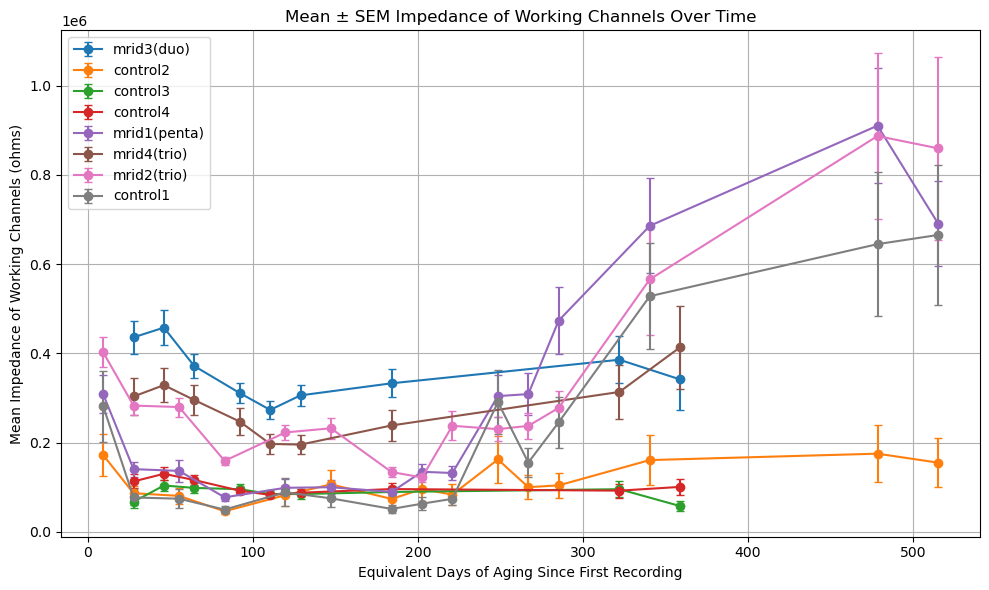


✅ Plot saved as PDF to: /Users/eminhanozil/Yanik Lab Dropbox/Eminhan Özil/Localization Manuscript 2024/in vitro/Accelerated Aging/impedances/


In [24]:
plot_working_channel_impedance_by_days_with_sem(data_by_category, main_folder)

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def compute_percentages(df_in: pd.DataFrame):
    if "Date" not in df_in.columns:
        raise ValueError('Input must contain a "Date" column.')

    df = df_in.copy()
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    if df["Date"].isna().any():
        bad = df[df["Date"].isna()].index.tolist()
        raise ValueError(f"Unparseable dates at rows: {bad}")

    df = df.sort_values("Date")

    categories = [c for c in df.columns if c != "Date"]

    # earliest non-NaN baseline per category
    baselines = {}
    for c in categories:
        s = df[c].dropna()
        baselines[c] = s.iloc[0] if not s.empty else float("nan")

    pct = df[categories].div(pd.Series(baselines), axis=1) * 100.0
    pct_df = pd.concat([df[["Date"]], pct], axis=1)
    return pct_df, baselines
    
from typing import Optional, Union

def plot_per_category(
    pct_df: pd.DataFrame,
    save_dir: Optional[Union[str, Path]] = None,
    show: bool = True
):
    date = pct_df["Date"]
    for col in [c for c in pct_df.columns if c != "Date"]:
        series = pct_df[col]
        if series.dropna().empty:
            continue

        plt.figure()
        plt.plot(date, series, marker="o")
        plt.title(f"{col} — % of baseline over time")
        plt.xlabel("Date")
        plt.ylabel("% of baseline")
        plt.grid(True, which="both", linestyle="--", alpha=0.5)
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()

        if save_dir is not None:
            save_dir = Path(save_dir)
            save_dir.mkdir(parents=True, exist_ok=True)
            out_path = save_dir / f"{col.replace('/', '_')}_percentage.png"
            plt.savefig(out_path, dpi=150)

        if show:
            plt.show()
        else:
            plt.close()

# Example usage:
# plot_per_category(pct_df, save_dir="percent_plots", show=True)
# plot_per_category(pct_df, save_dir=None, show=True)


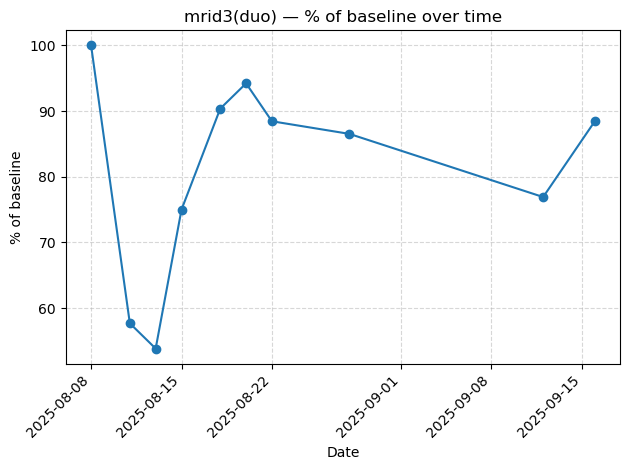

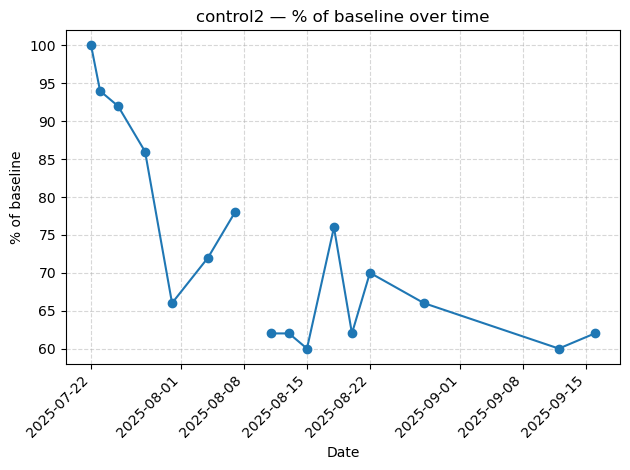

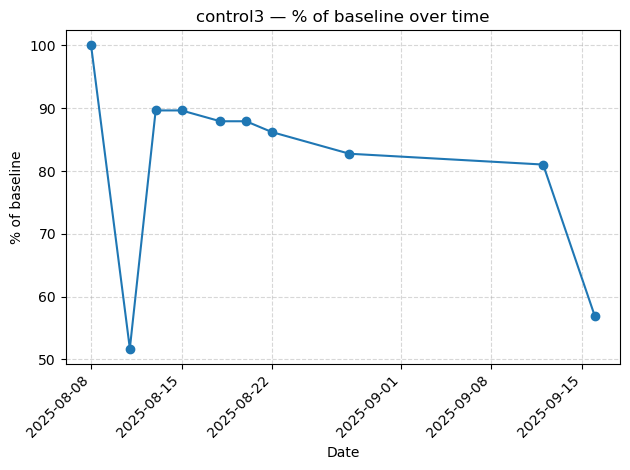

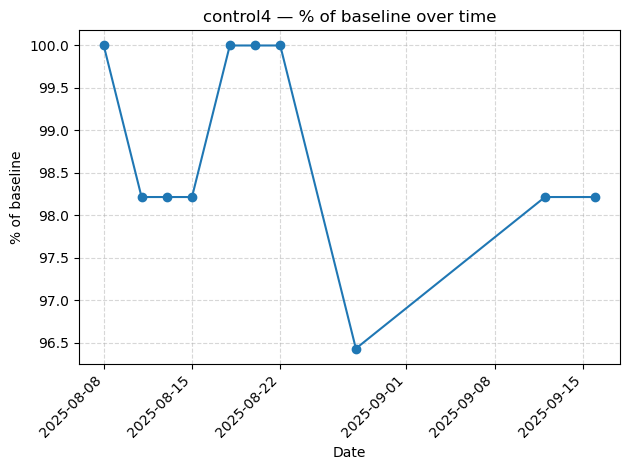

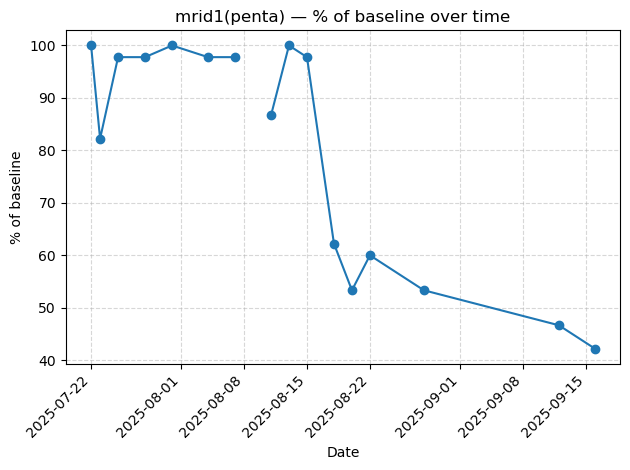

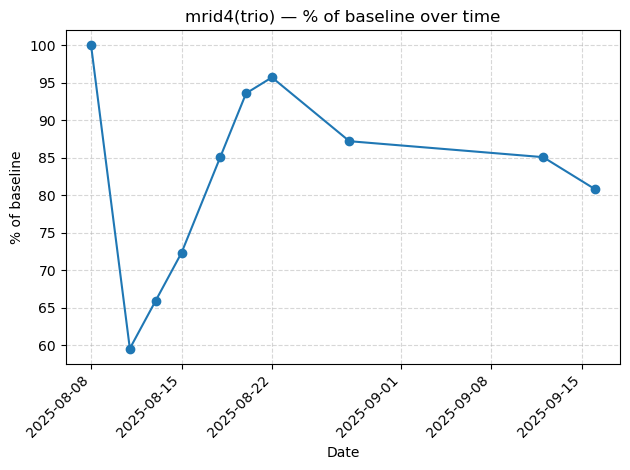

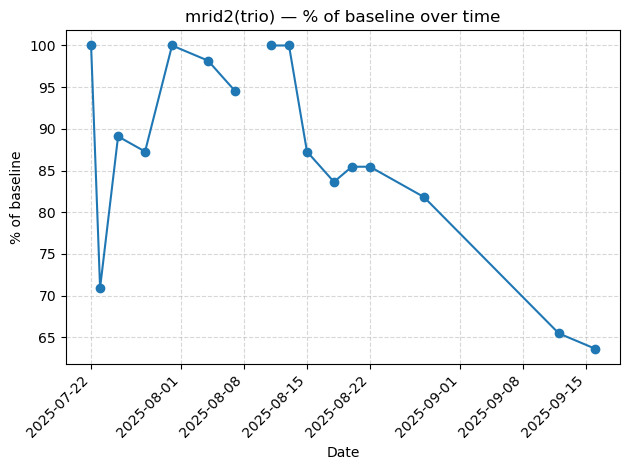

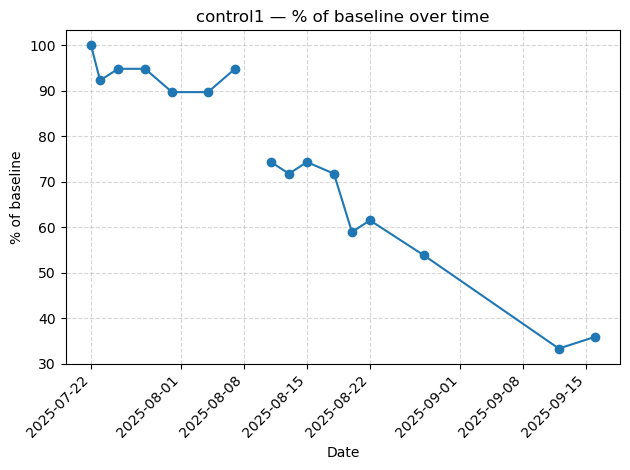

In [6]:
csv_path = os.path.join(main_folder, "working_channels_summary.csv")  # <- change if your file is elsewhere
df = pd.read_csv(csv_path)
df.head()

pct_df, baselines = compute_percentages(df)
pct_df.head()
plot_per_category(pct_df, save_dir=None, show=True)

In [7]:
pct_df

,Date,mrid3(duo),control2,control3,control4,mrid1(penta),mrid4(trio),mrid2(trio),control1
0,2025-07-22,NaN,100.0,NaN,NaN,100.000000,NaN,100.000000,100.000000
1,2025-07-23,NaN,94.0,NaN,NaN,82.222222,NaN,70.909091,92.307692
2,2025-07-25,NaN,92.0,NaN,NaN,97.777778,NaN,89.090909,94.871795
3,2025-07-28,NaN,86.0,NaN,NaN,97.777778,NaN,87.272727,94.871795
4,2025-07-31,NaN,66.0,NaN,NaN,100.000000,NaN,100.000000,89.743590
5,2025-08-04,NaN,72.0,NaN,NaN,97.777778,NaN,98.181818,89.743590
6,2025-08-07,NaN,78.0,NaN,NaN,97.777778,NaN,94.545455,94.871795
7,2025-08-08,100.000000,NaN,100.000000,100.000000,NaN,100.000000,NaN,NaN
8,2025-08-11,57.692308,62.0,51.724138,98.214286,86.666667,59.574468,100.000000,74.358974
9,2025-08-13,53.846154,62.0,89.655172,98.214286,100.000000,65.957447,100.000000,71.794872
